In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import Voutput as vp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from datetime import datetime
from sklearn.decomposition import PCA
from scipy import linalg
from PyAstronomy import pyasl 
import warnings
warnings.filterwarnings("ignore")

## 定义函数

In [2]:
#adf检验
def adf(df):
    p_list=[]
    t_list=[]
    currency_list=[]
    for currency in df.columns:
        currency_list.append(currency)
        test=list(adfuller(df.loc[:,currency]))
        t_list.append(test[0])
        p_list.append(test[1])
    return pd.DataFrame({'currency':currency_list,'t-test':t_list,'p-test':p_list})

In [3]:
#取窗口12个月，可以更改month的值
def window(df):
    month=24
    window_df_list=list()
    for i in range(len(df)-month+1):
        window_df_list.append(df.iloc[i:i+month])
    return window_df_list

In [4]:
#PCA，得到pc1作为共同冲击
def PCA_component_1(df):
    pca=PCA(n_components=1)
    tran=pd.DataFrame(pca.fit_transform(df),columns={'pc_1'})
    components=pd.DataFrame(pca.components_,columns=df.columns,index={'pc_1'})
    explained_variance=pca.explained_variance_ratio_
    return components

In [5]:
#去除共同冲击 
def extract_impact(df,pca):
    for column in df.columns:
        df[column]=df[column].values-float(pca[column])
    return df

In [6]:
#VAR模型，获得脉冲响应图
def var_model(df):
    diff1=df.diff(periods=1).dropna()
    var_mod=sm.tsa.VAR(diff1).fit()
    irf=var_mod.irf(15)
    return irf

In [7]:
#将irf数据点转为dataframe
class irf2df():  # 输出脉冲响应图数据
    def __init__(self, irf_obj):
        self.irf_obj = irf_obj
        self.get_names()
        self.irf_stderr()

    def irf_stderr(self):   #分别输出数据点和标准差
        self.irf_array=self.irf_obj.irfs
        datapoint=self.irf_array2df(self.irf_array)
        self.irf_datapoints=self.irf_df2csv(datapoint,'irf_datapoint')

        self.stderr_array=self.irf_obj.stderr()
        stderror = self.irf_array2df(self.stderr_array)
        self.irf_errorpoints=self.irf_df2csv(stderror, 'irf_stderror')

    def get_names(self):
        self.namelist=[]
        names=self.irf_obj.model.names  #变量名，查源码statsmodels/statsmodels/tsa/vector_ar/irf.py得到
        for i in names:
            temp1=str()
            temp1='->'+i
            for j in names:
                temp2=str()
                temp3=str()
                temp2=j
                temp3=temp2+temp1
                temp2=''
                self.namelist.append(temp3)

    def mergelist(self, array):  # 把多个array合并为一个list
        merged = []
        for i in range(len(array)):
            for j in list(array[i]):  # 把ndarray转为list
                merged.append(j)
        return merged

    def irf_array2df(self,input_array):
        self.array=input_array
        graphic_list =[]
        dot_list = []  # 按图像顺序记录最终点
        for i in self.array:
            graphic_list.append(i)
        graph_number = len(self.mergelist(graphic_list[0]))
        for index in range(graph_number):
            temp =[]
            for j in graphic_list:  # 获得一个图像的所有点
                temp.append(self.mergelist(j)[index])
            dot_list.append(temp)
        self.dot_df = pd.DataFrame(dot_list,dtype=np.float)
        return self.dot_df

    def irf_df2csv(self,input_df,category):
        input_df.insert(0,'冲击顺序',self.namelist)
        return input_df

In [8]:
#由irf数据点和方差数据点获得spillover矩阵
def spillover(irf_df,std_df):
    cum_series=irf_df.sum(axis=1)
    effect=dict()
    for index in std_df.index:
        cumulated=cum_series[index]
        effect[index]=[cumulated/i for i in std_df.drop([0],axis=1).loc[index]]

    effect_df=pd.DataFrame(effect)
    effect_df=pd.DataFrame(effect_df.values.T, index=effect_df.columns, columns=effect_df.index)
    spillovers=effect_df[0]
    #将seires转为矩阵
    temp=[]
    for i in range(0,len(spillovers),4):
        temp2=[]
        temp2=[spillovers[i],spillovers[i+1],spillovers[i+2],spillovers[i+3]]
        temp.append(temp2)
    spillover_df=pd.DataFrame(np.mat(temp),index=list(exchange_df.columns),columns=list(exchange_df.columns))

    #对角线取零（自己对自己的影响）
    np.fill_diagonal(spillover_df.values,0)

    #添加 FROM/TO
    spillover_df['FROM']=[row[1].mean() for row in spillover_df.iterrows()]
    spillover_df.loc['TO']=[column[1].mean() for column in spillover_df.iteritems()]

    #添加NET
    net_list=[]
    for column in exchange_df.columns:
        fr=spillover_df.loc[column][4]
        to=spillover_df[column][4]
        net_list.append(to-fr)
    net_list.append(0)
    spillover_df.loc['NET']=net_list

    #删除某些值
    spillover_df.loc['TO','FROM']=0
    #spillover_df.to_csv('../output/Spillovers.csv')
    return spillover_df

In [9]:
#使用ESD(Extreme Studentized Deviate test)剔除异常值
def ESD(df):
    for column in df.columns:
        r = pyasl.generalizedESD(np.array(df[column],dtype=float), 10, 0.05, fullOutput=True)
        for index in r[1]:
            df[column].iloc[index]=np.nan
    return df.dropna()

## 滚动窗口

In [10]:
exchange_df=pd.read_csv('../data/exchange_rate_data.csv').set_index('Collection')
exchange_df=exchange_df.iloc[60:len(exchange_df)] #选取07年之后的数据
#exchange_df=exchange_df.iloc[48:len(exchange_df)] #06
#exchange_df=exchange_df.iloc[72:len(exchange_df)] #08
window_df_list=window(exchange_df)

#adf(exchange_df).to_csv("adf1.csv")

In [12]:
to_df=pd.DataFrame(index=exchange_df.index[0:len(window_df_list)],columns=exchange_df.columns)
from_df=pd.DataFrame(index=exchange_df.index[0:len(window_df_list)],columns=exchange_df.columns)
net_df=pd.DataFrame(index=exchange_df.index[0:len(window_df_list)],columns=exchange_df.columns)
total_df=pd.DataFrame(index=exchange_df.index[0:len(window_df_list)],columns={'Total'})

In [13]:
for i in range(len(window_df_list)):
    window_df=window_df_list[i]
    #window_df=origin_df.diff(periods=1).dropna()
    pc_1=PCA_component_1(window_df)
    
    extract_df=extract_impact(window_df,pc_1)
    irf=var_model(extract_df)
    
    irf_df=irf2df(irf).irf_datapoints.set_index('冲击顺序')
    std_df=irf2df(irf).irf_errorpoints.set_index('冲击顺序')
    sp_df=spillover(irf_df,std_df)
    
    to_df.iloc[i]=sp_df.loc['TO',window_df.columns]
    from_df.iloc[i]=sp_df.loc[window_df.columns,'FROM']
    net_df.iloc[i]=sp_df.loc['NET',window_df.columns]
    total_df.iloc[i]=sum(sp_df.loc[window_df.columns,'FROM'])

Text(0, 0.5, 'To Effect')

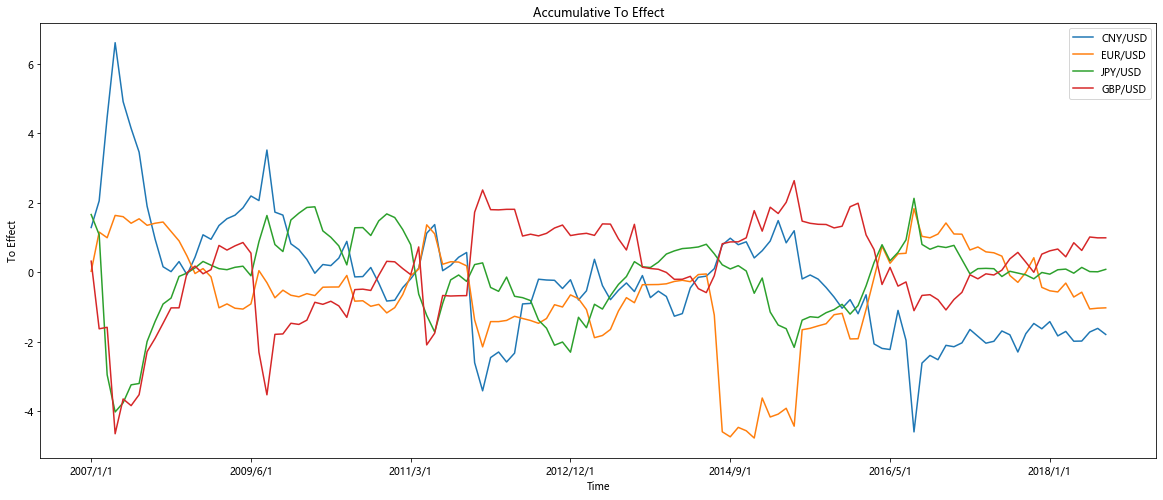

In [14]:
ESD(to_df).plot(figsize=(20,8),title='Accumulative To Effect')
plt.xlabel('Time')
plt.ylabel('To Effect')
#plt.savefig('2007to-24month.png')

Text(0, 0.5, 'From Effect')

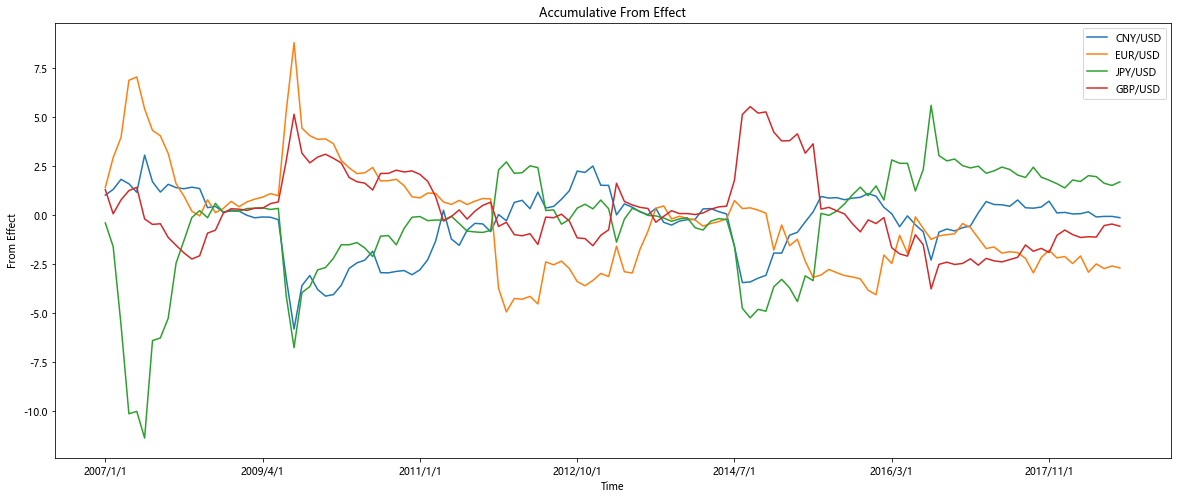

In [15]:
ESD(from_df).plot(figsize=(20,8),title='Accumulative From Effect')
plt.xlabel('Time')
plt.ylabel('From Effect')
#plt.savefig('2007from-24month.png')

Text(0, 0.5, 'Net Effect')

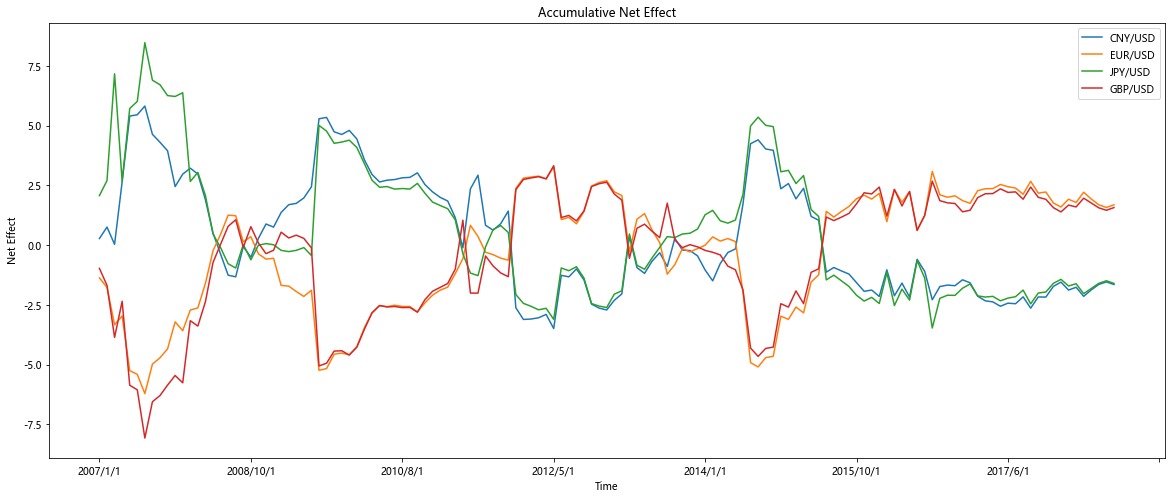

In [16]:
ESD(net_df).plot(figsize=(20,8),title='Accumulative Net Effect')
plt.xlabel('Time')
plt.ylabel('Net Effect')
#plt.savefig("2007net-24month.png")

Text(0, 0.5, 'Net Effect')

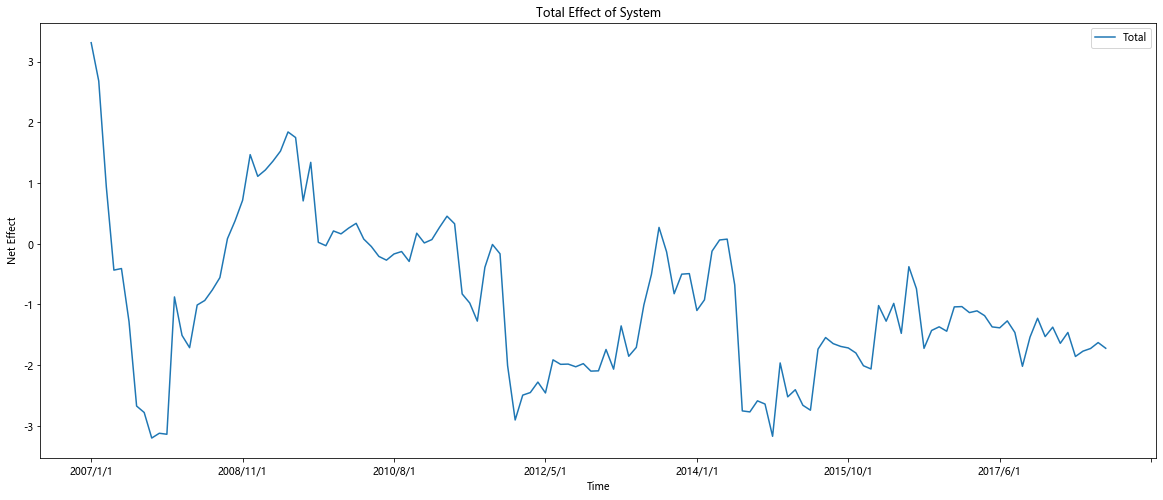

In [17]:
ESD(total_df).plot(figsize=(20,8),title='Total Effect of System')
plt.xlabel('Time')
plt.ylabel('Net Effect')
#plt.savefig("2007total-24month.png")